# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
from datetime import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [8]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [10]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [11]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [12]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

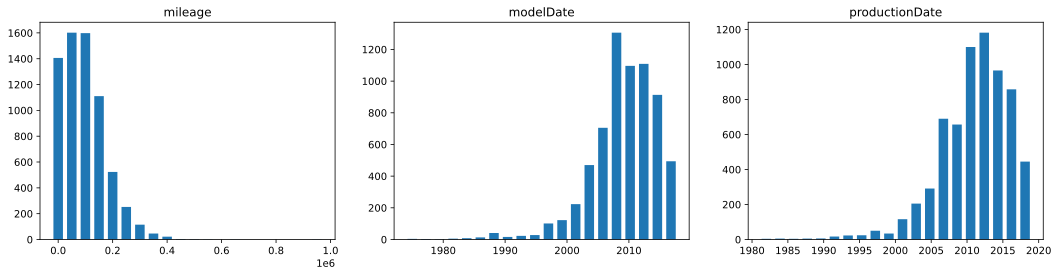

In [13]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
    columns = min(3, len(titles_values_dict))
    rows = (len(titles_values_dict) - 1) // columns + 1
    fig = plt.figure(figsize = (columns * 6, rows * 4))
    for i, (title, values) in enumerate(titles_values_dict.items()):
        hist, bins = np.histogram(values, bins = 20)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
        ax.set_title(title)
    plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

In [14]:
#profile = ProfileReport(train, title="Pandas Profiling Report")
#profile.to_file("car-price-train_profile.html")

In [15]:
# Профайлер не показал значительных вбросов в признаках
# Значительное количество пропусках в поле "Владение" (>50%) - не использовать

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
from sklearn.preprocessing import Normalizer, RobustScaler, StandardScaler
import category_encoders #.target_encoder.TargetEncoder

def one_hot_encode(df, feature):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(df[[feature]])
    encoder.transform(df[[feature]])
    return pd.DataFrame(encoder.transform(df[[feature]]), 
                        columns=encoder.get_feature_names([feature]),
                        index=df.index).astype(int)

def target_encode(df, feature, target):
    encoder = category_encoders.target_encoder.TargetEncoder()
    encoder.fit(df[[feature]], df[target])
    encoder.transform(df[[feature]])
    return pd.DataFrame(encoder.transform(df[[feature]]), 
                        columns[feature],
                        index=df.index).astype(int)

def scale(df, feature):
    encoder = MinMaxScaler()
#    encoder = RobustScaler()
#    encoder = StandardScaler()
    encoder.fit(df[[feature]])
    return encoder.transform(df[[feature]])


def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    output_df = df_input[['sample', 'price']].copy()
    # Body type
    output_df = pd.concat([output_df, one_hot_encode(df_input, 'bodyType')], axis=1)
    # Brand
    output_df = pd.concat([output_df, one_hot_encode(df_input, 'brand')], axis=1)
    # Color
    output_df = pd.concat([output_df, one_hot_encode(df_input, 'color')], axis=1)
    # engineDisplacement
    output_df['engineDisplacement'] = df_input['engineDisplacement'].apply(lambda x: x[:-4])
    output_df['engineDisplacement'] = output_df['engineDisplacement'].apply(
        lambda x: np.nan if x == 'undefined' else x).astype(float)
    output_df['engineDisplacement'].fillna(output_df['engineDisplacement'].median(), inplace=True)
    output_df['engineDisplacement'] = scale(output_df, 'engineDisplacement')
    # enginePower
    output_df['enginePower'] = df_input['enginePower'].apply(lambda x: x[:-4]).astype(int)
    output_df['enginePower'] = scale(output_df, 'enginePower')
    # fuelType
    output_df = pd.concat([output_df, one_hot_encode(df_input, 'fuelType')], axis=1)
    # model_info
    output_df = pd.concat([output_df, one_hot_encode(df_input, 'model_info')], axis=1)
    # numberOfDoors
    output_df = pd.concat([output_df, one_hot_encode(df_input, 'numberOfDoors')], axis=1)
    # vehicleTransmission
    output_df = pd.concat([output_df, one_hot_encode(df_input, 'vehicleTransmission')], axis=1)
    # owners
    output_df['owners'] = df_input['Владельцы'].fillna('3').apply(lambda x: x[0]).astype(int)
    # pts
    output_df['pts'] = df_input['ПТС'].map({'Оригинал': 0, 'Дубликат': 1})
    # Привод
    output_df = pd.concat([output_df, one_hot_encode(df_input, 'Привод')], axis=1)
    # Руль
    output_df['wheel'] = df_input['Руль'].map({'Левый': 0, 'Правый': 1})
    # productionDate
    output_df['productionDate'] = df_input['productionDate']
    output_df['productionDate'] = scale(output_df, 'productionDate')
    # age
    output_df['age'] = datetime.now().year - df_input['productionDate']
    output_df['age'] = scale(output_df, 'age')
    # modelDate
    output_df['modelDate'] = df_input['modelDate']
    output_df['modelDate'] = scale(output_df, 'modelDate')
    # millage
    output_df['mileage'] = df_input['mileage']
    output_df['mileage'] = scale(output_df, 'mileage') 
    
    # millage per year
#     output_df['mileage_per_year'] = df_input['mileage'] / (datetime.now().year - df_input['productionDate'])
#     output_df['mileage_per_year'] = min_max_scale(output_df, 'mileage_per_year') 
#     engineDisplacement = df_input['engineDisplacement'].apply(lambda x: x[:-4])
#     engineDisplacement = engineDisplacement.apply(lambda x: np.nan if x == 'undefined' else x).astype(float)
#     engineDisplacement.fillna(engineDisplacement.median(), inplace=True)
#     enginePower = df_input['enginePower'].apply(lambda x: x[:-4]).astype(int)

#     output_df['power_by_litre'] = enginePower / engineDisplacement
#     output_df['power_by_litre'] = min_max_scale(output_df, 'power_by_litre') 
#     output_df['mileage_per_year'] = min_max_scale(output_df, 'mileage_per_year') 
   
    
    return output_df

In [18]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,sample,price,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,...,owners,pts,Привод_задний,Привод_передний,Привод_полный,wheel,productionDate,age,modelDate,mileage
7399,1,1590000.0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0.868421,0.131579,0.895833,0.106999
4273,1,3100000.0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0.894737,0.105263,0.875000,0.044999
3362,1,3750000.0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,0,0.868421,0.131579,0.875000,0.054999
2794,1,1990000.0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,0,0.763158,0.236842,0.833333,0.124999
5378,1,1285000.0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,0,0.868421,0.131579,0.875000,0.148999
5902,1,3399999.0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0.815789,0.184211,0.854167,0.069799
1454,0,0.0,0,0,0,0,0,0,0,0,...,2,0,0,0,1,0,0.868421,0.131579,0.854167,0.052765
2476,1,700000.0,0,0,0,0,0,0,0,0,...,3,1,1,0,0,0,0.684211,0.315789,0.750000,0.173499
743,0,0.0,0,0,0,0,0,0,0,0,...,3,0,1,0,0,0,0.736842,0.263158,0.750000,0.119999
1168,0,0.0,0,1,0,0,0,0,0,0,...,3,0,0,0,1,0,0.842105,0.157895,0.854167,0.035999


In [19]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 184 entries, sample to mileage
dtypes: float64(7), int64(177)
memory usage: 11.7 MB


## Split data

In [20]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [21]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 183 entries, price to mileage
dtypes: float64(7), int64(176)
memory usage: 2.3 MB


# Model 2: CatBoostRegressor

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [23]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )

model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.0418896	test: 0.0419587	best: 0.0419587 (0)	total: 55.3ms	remaining: 4m 36s
100:	learn: 0.0128939	test: 0.0125611	best: 0.0125611 (100)	total: 355ms	remaining: 17.2s
200:	learn: 0.0103454	test: 0.0100418	best: 0.0100418 (200)	total: 642ms	remaining: 15.3s
300:	learn: 0.0097257	test: 0.0095000	best: 0.0095000 (300)	total: 933ms	remaining: 14.6s
400:	learn: 0.0093770	test: 0.0092531	best: 0.0092529 (399)	total: 1.21s	remaining: 13.9s
500:	learn: 0.0090622	test: 0.0090479	best: 0.0090479 (500)	total: 1.49s	remaining: 13.3s
600:	learn: 0.0087309	test: 0.0088066	best: 0.0088066 (600)	total: 1.76s	remaining: 12.9s
700:	learn: 0.0084647	test: 0.0086151	best: 0.0086151 (700)	total: 2.04s	remaining: 12.5s
800:	learn: 0.0082201	test: 0.0084600	best: 0.0084600 (800)	total: 2.34s	remaining: 12.2s
900:	learn: 0.0080063	test: 0.0083342	best: 0.0083342 (900)	total: 2.62s	remaining: 11.9s
1000:	learn: 0.0078514	test: 0.0082531	best: 0.0082531 (1000)	total: 2.9

In [24]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 10.98%


### Submission

In [25]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [26]:
X_train.head(5)

,bodyType_внедорожник 3 дв.,bodyType_внедорожник 5 дв.,bodyType_внедорожник открытый,bodyType_кабриолет,bodyType_компактвэн,bodyType_купе,bodyType_купе-хардтоп,bodyType_лимузин,bodyType_лифтбек,bodyType_минивэн,...,owners,pts,Привод_задний,Привод_передний,Привод_полный,wheel,productionDate,age,modelDate,mileage
7320,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0.763158,0.236842,0.770833,0.149999
8037,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0.947368,0.052632,0.937500,0.020941
4681,0,0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,0,0.631579,0.368421,0.687500,0.133896
6014,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,0,0,0.657895,0.342105,0.729167,0.329999
3649,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0.815789,0.184211,0.833333,0.125999


## Simple Dense NN

In [27]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.4))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.4))
model.add(L.Dense(1, activation="linear"))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               93696     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 225,281
Trainable params: 225,281
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [30]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [31]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

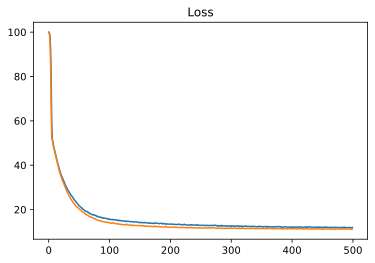

In [32]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [33]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [34]:
test_predict_nn1 = np.round(model.predict(X_test) / 1000) * 1000
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.21%


In [35]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

#### Логарифмирование числовых признаков и таргета хорошо сказывается на CatBoost, но сильно ухудшает NN (интересно почему?)

# Model 4: NLP + Multiple Inputs

In [36]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [37]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 1000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 128

In [38]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Tokenizer

In [39]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
word_freq = vectorizer.fit_transform(data.description)
word_freq = pd.DataFrame(word_freq.toarray(), columns=vectorizer.vocabulary_, index=data.index)

In [40]:
voc_dict = word_freq.sum()[(word_freq.sum() > 1) & (word_freq.sum() < 100)]
voc_dict

проект         9
универсал     54
sportline      3
модель        18
300            3
              ..
зависть       17
последним      5
мерседесом     2
оглядки        3
маркетинг      2
Length: 17555, dtype: int64

In [41]:
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, SnowballStemmer

stop_words = set(stopwords.words("russian"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stemmer = SnowballStemmer("russian")

def preprocces(X):
    X_proccess = []
    for x in tqdm(X):
        x = x.lower()
        x = nltk.word_tokenize(x)
        x = [word for word in x if word.isalnum()]
#       x = [lemmatizer.lemmatize(w) for w in x]
        x = [stemmer.stem(w) for w in x]
#        x = [word for word in x if not word in stop_words]
#       x = [word for word in x if  word in voc_dict]
        X_proccess.append(' '.join(x))
        
    return X_proccess

In [42]:
descriptions = preprocces(data.description)
data['prepared_desc'] = descriptions

100%|██████████| 8353/8353 [01:10<00:00, 118.34it/s]


In [43]:
text_train = data.prepared_desc.iloc[X_train.index]
text_test = data.prepared_desc.iloc[X_test.index]
text_sub = data.prepared_desc.iloc[X_sub.index]


In [44]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.prepared_desc)

CPU times: user 1.15 s, sys: 3.41 ms, total: 1.16 s
Wall time: 1.16 s


In [45]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 128) (1003, 128) (1671, 128)
CPU times: user 1.13 s, sys: 595 µs, total: 1.13 s
Wall time: 1.13 s


In [46]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

автомобил провер по 110 пункт автокред по специальн ставк от ауд центр север официальн дилер aud входя в групп компан рольф и явля одн из крупн дилер в европ предлага вам ряд услуг по покупк и продаж автомобил с пробег на протяжен мног лет наш дилерск центр явля лидер по продаж автомобил с пробег сред всех дилер aud в росс и предоставля клиент сам больш выбор автомобил с пробег aud и друг марок кажд автомобил проход тщательн диагностик и подготовк и гарантирова наход в отличн состоян чтоб убед в правильн выбор у вас ест возможн пройт ознакомительн поездк на интерес автомобил вы сможет ознаком с автомобил не выход из дом наш менеджер проведет onlin презентац и в видеозвонк покажет выбра автомобил такж ауд центр север представля уникальн предложен по кредитован автомобил с пробег на индивидуальн услов специалист компан подберут для вас лучш услов кредитован бол 6 000 проверен автомобил с пробег с гарант до 2 лет ждут вас на сайт и в мобильн приложен мо рольф
[383  24   1 455 263 283 361 

In [47]:
# Уменьшение MAX_WORDS 1000 дало небольшой прирост в метрике (?) и увеличило скорость обучения

### RNN NLP

In [48]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
#model_nlp.add(L.Dropout(0.25))

In [49]:
#!pip install tensorflow-text==2.3.0

In [50]:
#import tensorflow_text as text  # Registers the ops.
#import tensorflow_hub as hub

In [51]:
# tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4'
# tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

# def build_classifier_model():
#     text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
#     preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing', trainable=False)
#     encoder_inputs = preprocessing_layer(text_input)
#     encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')
#     outputs = encoder(encoder_inputs)
#     net = outputs['pooled_output']
#     net = tf.keras.layers.LSTM(256, return_sequences=True)(outputs['sequence_output'])
#     net = tf.keras.layers.Dropout(0.25)(net)
#     net = tf.keras.layers.LSTM(128,)(net)
#     net = tf.keras.layers.Dropout(0.25)(net)
#     net = tf.keras.layers.Dense(64, activation="relu")(net)
#     return tf.keras.Model(text_input, net)

In [52]:
#model_nlp = build_classifier_model()

In [53]:
# Использование BERT не дало существенного выйгрыша в метрике, но значительно повлияло на время и память GPU

### MLP

In [54]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.4))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.4))

### Multiple Inputs NN

In [55]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [56]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 128)     2567424     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128, 256)     394240      embedding[0][0]                  
__________________________________________________________________________________________________
dense_4_input (InputLayer)      [(None, 182)]        0                                            
_______________________________________________________________________________________

### Fit

In [57]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [58]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [59]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 2s 169ms/step - loss: 99.9858 - MAPE: 99.9858 - val_loss: 99.8403 - val_MAPE: 99.8403
Epoch 2/500
12/12 [==============================] - 1s 110ms/step - loss: 98.6295 - MAPE: 98.6295 - val_loss: 93.7377 - val_MAPE: 93.7377
Epoch 3/500
12/12 [==============================] - 1s 106ms/step - loss: 79.7750 - MAPE: 79.7750 - val_loss: 53.0511 - val_MAPE: 53.0511
Epoch 4/500
12/12 [==============================] - 1s 105ms/step - loss: 54.3717 - MAPE: 54.3717 - val_loss: 50.5506 - val_MAPE: 50.5506
Epoch 5/500
12/12 [==============================] - 1s 111ms/step - loss: 49.4185 - MAPE: 49.4185 - val_loss: 47.8281 - val_MAPE: 47.8281
Epoch 6/500
12/12 [==============================] - 1s 103ms/step - loss: 46.1864 - MAPE: 46.1864 - val_loss: 45.1067 - val_MAPE: 45.1067
Epoch 7/500
12/12 [==============================] - 1s 107ms/step - loss: 43.8645 - MAPE: 43.8645 - val_loss: 42.4049 - val_MAPE: 42.4049
Epoch 8/500
12/12 [========

In [60]:
# history = model.fit([text_train, X_train], y_train,
#                     batch_size=32,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=([text_test, X_test], y_test),
#                     callbacks=callbacks_list
#                    )

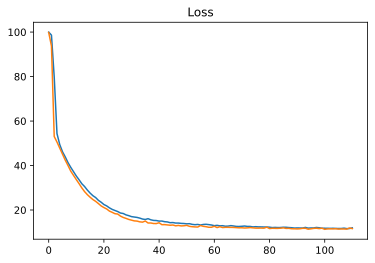

In [61]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [62]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [63]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.64%


In [64]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

### Обработка текстогого описания не дало прироста в метрике, но возможно положительно скажется если использовать результаты в blende

# Model 5: Добавляем картинки

### Data

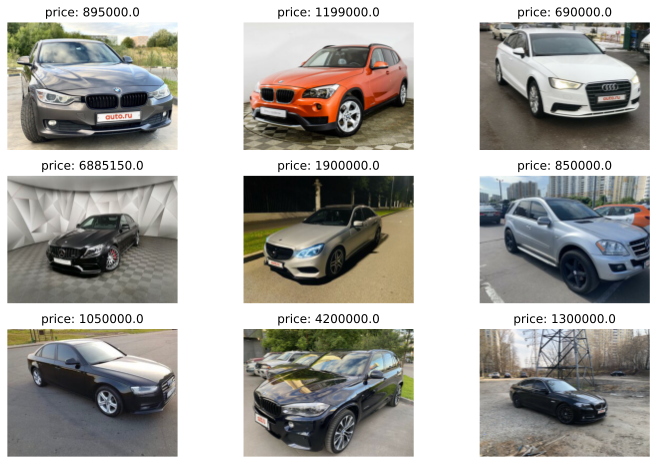

In [65]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [66]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

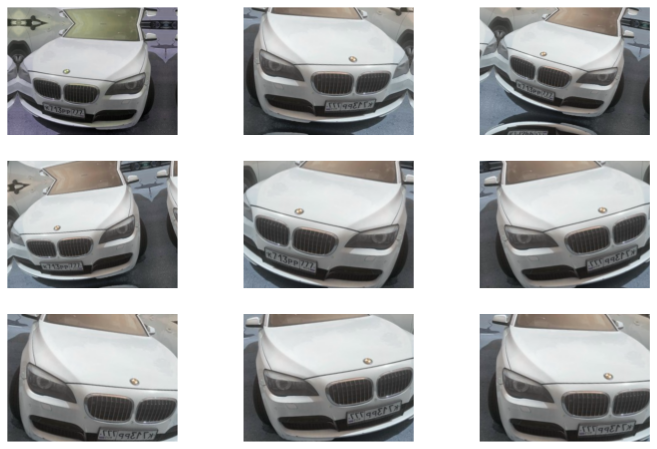

In [67]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
#     OneOf([
#         IAAAdditiveGaussianNoise(),
#         GaussNoise(),
#     ], p=0.2),
#     OneOf([
#         MotionBlur(p=0.2),
#         MedianBlur(blur_limit=3, p=0.1),
#         Blur(blur_limit=3, p=0.1),
#     ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
#     OneOf([
#         OpticalDistortion(p=0.3),
#         GridDistortion(p=0.1),
#         IAAPiecewiseAffine(p=0.3),
#     ], p=0.2),
#     OneOf([
#         CLAHE(clip_limit=2),
#         IAASharpen(),
#         IAAEmboss(),
#         RandomBrightnessContrast(),
#     ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [68]:
# Уменьшение разнообразия послк аугментации дает небольшой прирост метрики, но если вообще убрать метрика ухудшается

In [69]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [70]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.prepared_desc)

In [71]:
def process_image(image):
    return augmentation(image = image.numpy())['image']
#    return image

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.prepared_desc.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.prepared_desc.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.prepared_desc.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [72]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_model.trainable = False
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
efficientnet_output = L.Dense(512, activation="relu")(efficientnet_output)
efficientnet_output = L.Dropout(0.5)(efficientnet_output)
efficientnet_output = L.Dense(256, activation="relu")(efficientnet_output)

43941888/43941136 [==============================] - 0s 0us/step


In [73]:
# Resnet50V2
#resnet50V2_model = tf.keras.applications.resnet_v2.ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
#resnet50V2_output = L.GlobalAveragePooling2D()(resnet50V2_model.output)

# Не дал выйгрыша

In [74]:
# MobileNetV2
#MobileNetV2_model  = tf.keras.applications.MobileNetV2(
#    input_shape= (size[1], size[0], 3), alpha=1.0, include_top=False,
#    weights='imagenet', classifier_activation='linear'
#)
#MobileNetV2_model.trainable = False
#MobileNetV2_output = L.GlobalAveragePooling2D()(MobileNetV2_model.output)

# Не дал выйгрыша

In [75]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.4),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.4),
    ])

In [76]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [77]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(128, activation="linear")(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [78]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [79]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [80]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 34s 178ms/step - loss: 55.7291 - MAPE: 55.7291 - val_loss: 32.4640 - val_MAPE: 32.4640
Epoch 2/100
190/190 [==============================] - 30s 158ms/step - loss: 29.0345 - MAPE: 29.0345 - val_loss: 24.1114 - val_MAPE: 24.1114
Epoch 3/100
190/190 [==============================] - 30s 156ms/step - loss: 21.8914 - MAPE: 21.8914 - val_loss: 17.5489 - val_MAPE: 17.5489
Epoch 4/100
190/190 [==============================] - 30s 158ms/step - loss: 18.3676 - MAPE: 18.3676 - val_loss: 15.2934 - val_MAPE: 15.2934
Epoch 5/100
190/190 [==============================] - 30s 157ms/step - loss: 16.8609 - MAPE: 16.8609 - val_loss: 14.5343 - val_MAPE: 14.5343
Epoch 6/100
190/190 [==============================] - 30s 157ms/step - loss: 15.6176 - MAPE: 15.6176 - val_loss: 13.0880 - val_MAPE: 13.0880
Epoch 7/100
190/190 [==============================] - 30s 157ms/step - loss: 15.0499 - MAPE: 15.0499 - val_loss: 12.7580 - val_MAPE: 12.7580
Epoch 

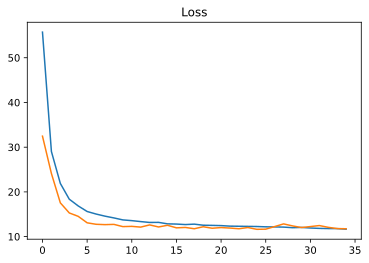

In [81]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [82]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [83]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.75%


In [84]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

### Обработка картинок не дало прироста в метрике, но возможно положительно скажется если использовать результаты в blende


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [85]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.52%


In [86]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [87]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.4))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.4))

In [88]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [89]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [90]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_15_input (InputLayer)     [(None, 182)]        0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 512)          93696       dense_15_input[0][0]             
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 512)          0           dense_15[0][0]                   
__________________________________________________________________________________________________
productiondate (InputLayer)     [(None, 1)]          0                                            
_______________________________________________________________________________________

In [91]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [92]:
history = model.fit([X_train, X_train.productionDate.values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, X_test.productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 20ms/step - loss: 99.9768 - MAPE: 99.9768 - val_loss: 99.7553 - val_MAPE: 99.7553
Epoch 2/500
12/12 [==============================] - 0s 8ms/step - loss: 98.1015 - MAPE: 98.1015 - val_loss: 91.7009 - val_MAPE: 91.7009
Epoch 3/500
12/12 [==============================] - 0s 8ms/step - loss: 75.1910 - MAPE: 75.1910 - val_loss: 51.8212 - val_MAPE: 51.8212
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 53.9023 - MAPE: 53.9023 - val_loss: 49.6068 - val_MAPE: 49.6068
Epoch 5/500
12/12 [==============================] - 0s 8ms/step - loss: 49.1955 - MAPE: 49.1955 - val_loss: 47.0133 - val_MAPE: 47.0133
Epoch 6/500
12/12 [==============================] - 0s 9ms/step - loss: 45.7174 - MAPE: 45.7174 - val_loss: 44.3495 - val_MAPE: 44.3495
Epoch 7/500
12/12 [==============================] - 0s 9ms/step - loss: 43.1728 - MAPE: 43.1728 - val_loss: 41.6928 - val_MAPE: 41.6928
Epoch 8/500
12/12 [=====================

In [93]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 11.80%


#### Блендинг предыдущих моделей + усреднение значений катбуста и простой сети на 5 фолдах
Так как на лидерборде значение скор значительно падает поробую усреднить значенияпредыдущих моделей

In [94]:
mlp_model = Sequential()
mlp_model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
mlp_model.add(L.Dropout(0.4))
mlp_model.add(L.Dense(256, activation="relu"))
mlp_model.add(L.Dropout(0.4))
mlp_model.add(L.Dense(1, activation="linear"))
mlp_model.summary()

# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
mlp_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]


df_preproc = preproc_data(data)
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
train_data.reset_index(drop=True, inplace=True)
y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)


from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
kf.get_n_splits(train_data)

n = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    cat_boost_model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
    cat_boost_model.fit(X, np.log(y),
             eval_set=(X_test, np.log(y_test)),
             verbose_eval=1000,
             use_best_model=True)
             #plot=True)
    test_predict_cat_boost = np.exp(cat_boost_model.predict(X_test))
    print(f"TEST mape: {(mape(y_test, test_predict_cat_boost))*100:0.2f}%")
    sub_predict_catboost = np.exp(cat_boost_model.predict(X_sub))
    sample_submission[f'catboost_price_{n}'] = sub_predict_catboost
    n = n + 1

    
n = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    
    mlp_model = Sequential()
    mlp_model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
    mlp_model.add(L.Dropout(0.4))
    mlp_model.add(L.Dense(256, activation="relu"))
    mlp_model.add(L.Dropout(0.4))
    mlp_model.add(L.Dense(1, activation="linear"))
    
    optimizer = tf.keras.optimizers.Adam(0.01)
    mlp_model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
    
    history = mlp_model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )
    test_predict_nn1 = mlp_model.predict(X_test)
    print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")
    
    sub_predict_nn1 = mlp_model.predict(X_sub)
    sample_submission[f'mlp_price_{n}'] = sub_predict_nn1[:,0]
    n = n + 1


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               93696     
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 225,281
Trainable params: 225,281
Non-trainable params: 0
_________________________________________________________________
Learning rate set to 0.024207
0:	learn: 0.0418400	test: 0.0424432	best: 0.0424432 (0)	total: 4.57ms	remaining: 22.

In [95]:
sample_submission['price_nn3'] = sub_predict_nn3[:,0]
sample_submission['price_nn2'] = sub_predict_nn2[:,0]

In [96]:
columns = ['catboost_price_1', 'catboost_price_2', 'catboost_price_3', 'catboost_price_4', 'catboost_price_5', 
           'mlp_price_1', 'mlp_price_2', 'mlp_price_3', 'mlp_price_4', 'mlp_price_5', 'price_nn2', 'price_nn3']
sample_submission['price'] = np.round(sample_submission[columns].mean(axis=1) / 1000) * 1000

In [97]:
sample_submission[['sell_id','price']].to_csv('submission.csv', index=False)

### Выводы: 
Скорее всего ухудшение скора на моделях с использованием NLP и CV связано с недостатком опыта их использования, но по факту значение метрики ухудшается.
Усреднение результатов при делении тренировочного сета на 5 фолдов не улучшило метрику на трейн/тесте, но позволило улучшить результаты в лидерборде.